In [89]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import time
from torch.optim.lr_scheduler import MultiStepLR
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.')


Using cuda.


**Dataset**

The CIFAR-10 dataset is composed of 60000 small (3 × 32 × 32) color images in 10 classes, with 6000 images per class.
(classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck)
Training Dataset : 50000 ( 5 training Batch, each with 10000 images )
Testing Dataset : 10000 (1 Test Batch )

Created a DataLoader for the training dataset and a DataLoader for the testing dataset, with the selected number of Batch Size. 

**Data augmentation on training data :**

**transforms.RandomHorizontalFlip():** Randomly flips the images horizontally, which effectively doubles the variety of horizontal orientations in the dataset.

**transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)** transformation randomly adjusts the brightness, contrast, saturation, and hue of images to enhance data variability and model robustness during training.



In [90]:
def load_data_CIFAR10(batch_size, resize=None):
    # Download the CIFAR-10 dataset and then load it into memory
    
    # Define the transformations
    if resize:
        train_trans = [transforms.RandomHorizontalFlip(p=0.5),transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), transforms.ToTensor()]
 
        test_trans = [transforms.ToTensor()]
    else:
        train_trans = [transforms.RandomHorizontalFlip(p=0.5), transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), transforms.ToTensor()]

        test_trans = [transforms.ToTensor()]

    # Compose the transformations
    train_transforms = transforms.Compose(train_trans)
    test_transforms = transforms.Compose(test_trans)

    # Load the CIFAR-10 dataset with the transformations
    train = torchvision.datasets.CIFAR10(root="../data", train=True, transform=train_transforms, download=True)
    test = torchvision.datasets.CIFAR10(root="../data", train=False, transform=test_transforms, download=True)

    # Return the dataloaders
    return (torch.utils.data.DataLoader(train, batch_size, shuffle=True, num_workers=2),
            torch.utils.data.DataLoader(test, batch_size, shuffle=False, num_workers=2))


In [91]:
# Defines the batch size
batch_size = 50

# Loads the fashion CIFAR-10 dataset. `train_iter` and `test_iter` are `DataLoader` objects.
train_iter, test_iter = load_data_CIFAR10(batch_size, resize=(32,32))

Files already downloaded and verified
Files already downloaded and verified


In [92]:
# Requests the first training batch
X, y = next(iter(train_iter))

# 50 images per batch size defined above
print(X.size())
# Expected output for colored images: [50, 3, 32, 32]

print(y.size())
# Expected output: [50], representing 50 targets

torch.Size([50, 3, 32, 32])
torch.Size([50])


**Basic architecture**

Implement the neural network architecture , which is composed of a sequence of intermediate blocks B1, B2, . . . , BK that are followed by an output block O

* **Objective**: Implement a neural network architecture based on the described structure that inherits from `torch.nn.Module`.

* **Input/Output**: The network processes a $1 \times 32 \times 32$ coloured image and outputs a 10-element vector representing class probabilities.



**Step 1: Define the Intermediate Block**
Each intermediate block should contain multiple convolutional layers whose outputs are combined using coefficients derived from the input image's channel averages.

**NOTE:** Implemented My Neural Network Architecture Based on Basic Architecture

In [93]:
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers,dropout_rate=0.5):
        super(IntermediateBlock, self).__init__()
        self.num_layers = num_layers
        
        self.conv_layers = nn.ModuleList()
        self.activation = nn.ModuleList() 
        self.max_pool= nn.ModuleList() #Add Max pooling
        self.batch_norm = nn.ModuleList() #Add batch normalisation
        self.dropout = nn.ModuleList()  # Add a ModuleList for dropout layers
        for _ in range(num_layers):
            self.conv_layers.append(nn.Conv2d(in_channels, out_channels,kernel_size=6, padding=2))
            self.activation.append(torch.nn.ReLU())
            self.batch_norm.append(torch.nn.BatchNorm2d(out_channels))
            self.max_pool.append(torch.nn.MaxPool2d(kernel_size=3,stride = 2, padding=1))
            self.dropout.append(nn.Dropout(dropout_rate))  # Add dropout with the specified rate
        
        # Update the linear layer to match the out_channels of the conv layers
        self.fc = nn.Linear(in_channels, num_layers)  
        self.sigm = torch.nn.Sigmoid()

    def forward(self, x):
        m = torch.mean(x, dim=[2, 3])  # Average over spatial dimensions
        
        # spatial dimensions, m should now be [batch_size]
        a = self.fc(m)
        a = self.sigm(a)

        conv_outputs = []
   
        for conv_layer,activation,max_pool,bn,dropout in zip(self.conv_layers,self.activation,self.max_pool,self.batch_norm,self.dropout):
            conv_out = conv_layer(x)
            conv_out = max_pool(conv_out)
            conv_out = bn(conv_out)
            conv_out = activation(conv_out)
            conv_out = dropout(conv_out)  # Apply dropout after batch normalization
            conv_outputs.append(conv_out)
            
        a = a.view(a.size(0), self.num_layers, 1, 1)
        
        x_prime = torch.sum(torch.stack([a[:, i].unsqueeze(1) * conv_outputs[i] 
                                         for i in range(self.num_layers)], dim=1), dim=1)
        return x_prime


**Step 2: Define the Output Block**
The output block takes the last intermediate block's output, processes it through fully connected layers, and produces the logits vector.

In [94]:
class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(OutputBlock, self).__init__()
        self.fc1 = nn.Linear(in_channels, num_classes)  
        # self.sigm = torch.nn.Sigmoid()

    def forward(self, x):
        m = torch.mean(x, dim=[2, 3])  
        o = self.fc1(m)  # Compute logits vector
     
        return o


**Step 3: Assemble the Complete Model**
Now, we combine intermediate blocks and the output block into the final model.

In [95]:
class MyCIFAR10Net(nn.Module):
    def __init__(self, num_classes):
        super(MyCIFAR10Net, self).__init__()
        # Define the sequence of blocks. 
        self.block1 = IntermediateBlock(3, 128, 3)   # Input: 3 channels, Output: 128 channels,  3 conv layers
        self.block2 = IntermediateBlock(128, 64, 3) # Input: 128 channels (from block1), Output: 64 channels ,  3 conv layers
        self.block3 = IntermediateBlock(64, 32, 3)  # Example: 3 conv layers, input: 64 channels, output: 32 channels
        self.output_block = OutputBlock(32, num_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        logits = self.output_block(x)
        return logits


**Applies Xavier initialization if the `torch.nn.Module` is `torch.nn.Linear` or `torch.nn.Conv2d`**

In [96]:
# Applies Xavier initialization if the `torch.nn.Module` is `torch.nn.Linear` or `torch.nn.Conv2d`
def init_weights(m):
    if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)

**Final Model after experimenting with hyperparameters**

In [97]:
# Call final Model
FinalModel = MyCIFAR10Net(10).to(device)
FinalModel.apply(init_weights)

MyCIFAR10Net(
  (block1): IntermediateBlock(
    (conv_layers): ModuleList(
      (0-2): 3 x Conv2d(3, 128, kernel_size=(6, 6), stride=(1, 1), padding=(2, 2))
    )
    (activation): ModuleList(
      (0-2): 3 x ReLU()
    )
    (max_pool): ModuleList(
      (0-2): 3 x MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (batch_norm): ModuleList(
      (0-2): 3 x BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (dropout): ModuleList(
      (0-2): 3 x Dropout(p=0.5, inplace=False)
    )
    (fc): Linear(in_features=3, out_features=3, bias=True)
    (sigm): Sigmoid()
  )
  (block2): IntermediateBlock(
    (conv_layers): ModuleList(
      (0-2): 3 x Conv2d(128, 64, kernel_size=(6, 6), stride=(1, 1), padding=(2, 2))
    )
    (activation): ModuleList(
      (0-2): 3 x ReLU()
    )
    (max_pool): ModuleList(
      (0-2): 3 x MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (batch_n

**Cross-entropy loss function :**

* The *convolutional neural network* defined above computes the logits matrix $\mathbf{O}$

* This is because PyTorch provides a class called `CrossEntropyLoss` that implements the desired cross entropy loss but requires a logits matrix $\mathbf{O}$ instead of the prediction matrix $\mathbf{\hat{Y}}$.

* The class `CrossEntropyLoss` implements the cross entropy loss in a way that avoids numerical instabilities that would result from a naive implementation.

In [98]:
# cross-entropy loss function
loss = torch.nn.CrossEntropyLoss()

**Optimization Algorithm :**

* I employed Adam optimier with a learning rate of $0.03$ as the optimization algorithm.

* implemented a subclass of `torch.nn.Module`, the model parameters can be accessed through the method `parameters`.

In [99]:
# Learning Rate(lr) and Optimizer
lr = 0.003

# Choosing Adam as optimizer 
optimizer = torch.optim.Adam(FinalModel.parameters(), lr=lr)

#The `scheduler` uses `MultiStepLR` to adjust the learning rate of the `optimizer` by a factor of `0.8`.
steps = [15,25,40]
scheduler = MultiStepLR(optimizer,milestones = steps, gamma = 0.8)

**Evaluation :**

**Function correct(logits, y)** takes the logits from model and the true labels y.
It uses argmax to find the predicted class and compares it to the true labels to compute the accuracy and calculates the number of correct predictions.

In [100]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.


**Function evaluate_metric(model, data_iter, metric)** : This function appears to be set up for computing the average of a metric over a dataset.It iterates through the data loader, calculates logits, and applies a provided metric function to the logits and true labels. The metric in c and the number of samples in n, then return the average metric.

The metric function passed to evaluate_metric should be designed to return a scalar value for the metric being evaluated.


In [101]:
def evaluate_metric(model, data_iter, metric):
    # Compute the average `metric` of the model on a dataset.
    c = torch.tensor(0.,device = device)
    n = torch.tensor(0.,device = device)
    for i, data in enumerate(data_iter , 0):
      inputs, label = data[0].to(device), data[1].to(device)
      logits = model(inputs)
      c += metric(logits, label)
      n += len(label)
    return c / n

**Training and Testing**

In [102]:
# Intial Train and Test Accuracy
FinalModel.eval()
print(f'Training accuracy: {evaluate_metric(FinalModel, train_iter, correct)}. Testing accuracy: {evaluate_metric(FinalModel, test_iter, correct)}.')

Training accuracy: 0.10000000149011612. Testing accuracy: 0.10000000149011612.


* The following code implements the training loop for the convolutional neural network.

* The training/testing dataset accuracy is displayed after each epoch and stored for plotting.


Epoch 1/50.
Training accuracy: 0.40202000737190247. Testing accuracy: 0.40860000252723694. Duration: 33.005s.

Epoch 2/50.
Training accuracy: 0.6850000023841858. Testing accuracy: 0.683899998664856. Duration: 35.158s.

Epoch 3/50.
Training accuracy: 0.6883999705314636. Testing accuracy: 0.6850000023841858. Duration: 33.353s.

Epoch 4/50.
Training accuracy: 0.7600200176239014. Testing accuracy: 0.7544000148773193. Duration: 33.582s.

Epoch 5/50.
Training accuracy: 0.7557399868965149. Testing accuracy: 0.7491999864578247. Duration: 33.362s.

Epoch 6/50.
Training accuracy: 0.7875800132751465. Testing accuracy: 0.7756999731063843. Duration: 34.971s.

Epoch 7/50.
Training accuracy: 0.7914000153541565. Testing accuracy: 0.7781999707221985. Duration: 31.718s.

Epoch 8/50.
Training accuracy: 0.8030800223350525. Testing accuracy: 0.7865999937057495. Duration: 33.134s.

Epoch 9/50.
Training accuracy: 0.8118199706077576. Testing accuracy: 0.7907999753952026. Duration: 32.530s.

Epoch 10/50.
Trai

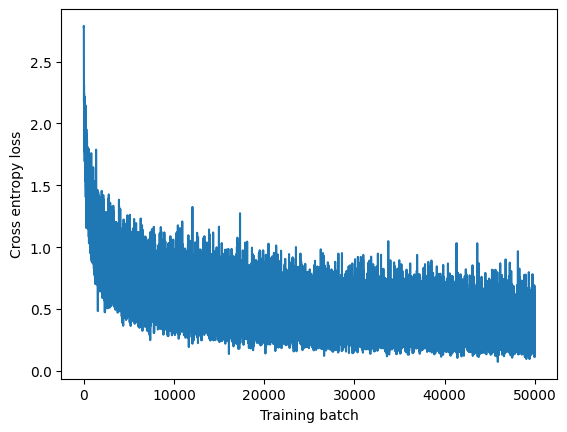

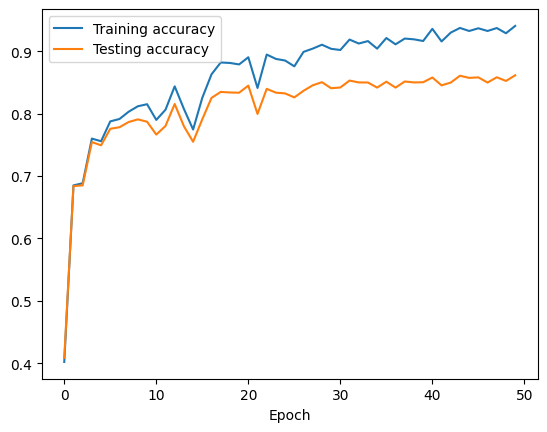

In [103]:
losses = [] # Stores the loss for each training batch
train_accs = [] # Stores the training accuracy after each epoch
test_accs = [] # Stores the testing accuracy after each epoch

num_epochs = 50
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}.')
    start_time = time.perf_counter()

    FinalModel.train() 

    for X, y in train_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = FinalModel(X) # Computes the logits for the batch of images `X`

        l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
        optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
        l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

        optimizer.step() # Updates the model parameters based on the gradients stored inside them

        losses.append(float(l)) # Stores the loss for this batch
    scheduler.step()

    with torch.no_grad(): # Computing performance metrics does not require gradients
        FinalModel.eval() # This is necessary because batch normalization behaves differently between training and evaluation
        train_accs.append(evaluate_metric(FinalModel, train_iter, correct))
        test_accs.append(evaluate_metric(FinalModel, test_iter, correct))

        end_time = time.perf_counter()

        print(f'Training accuracy: {train_accs[-1]}. Testing accuracy: {test_accs[-1]}. Duration: {end_time - start_time:.3f}s.') # Computes and displays training/testing dataset accuracy.




plt.plot(losses) # Plots the loss for each training batch
plt.xlabel('Training batch')
plt.ylabel('Cross entropy loss')
plt.show()


plt.plot([t.cpu() for t in train_accs], label='Training accuracy')
plt.plot([t.cpu() for t in test_accs], label='Testing accuracy')


plt.legend(loc='best')
plt.xlabel('Epoch')
plt.show()